In [1]:
import torchvision as tv
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torch
import matplotlib.pyplot as plt
torch.set_grad_enabled(False)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import torchvision.ops as ops
from torchvision.ops import box_area, box_iou
import random

import collections
import math
import pathlib
import warnings
from itertools import repeat
from types import FunctionType
from typing import Any, BinaryIO, List, Optional, Tuple, Union

import numpy as np
import torch
from PIL import Image, ImageColor, ImageDraw, ImageFont

from copy import copy


def filter_boxes(instances, threshold=0.0):
    indexes = instances.scores >= threshold
    assert indexes.sum() > 0
    boxes = instances.pred_boxes.tensor[indexes, :]
    pred_classes = instances.pred_classes[indexes]
    return boxes, pred_classes, instances.scores[indexes]


def assign_colors(pred_classes, label_names, seed=1):
    all_classes = torch.unique(pred_classes).tolist()
    all_classes = list(set([label_names[ci] for ci in all_classes]))
    colors = list(sns.color_palette("hls", len(all_classes)).as_hex())
    random.seed(seed)
    random.shuffle(colors)
    class2color = {}
    for cname, hx in zip(all_classes, colors):
        class2color[cname] = hx
    colors = [class2color[label_names[cid]] for cid in pred_classes.tolist()]
    return colors

def draw_bounding_boxes(
    image: torch.Tensor,
    boxes: torch.Tensor,
    labels: Optional[List[str]] = None,
    colors: Optional[Union[List[Union[str, Tuple[int, int, int]]], str, Tuple[int, int, int]]] = None,
    fill: Optional[bool] = False,
    width: int = 1,
    font: Optional[str] = None,
    font_size: Optional[int] = None,
) -> torch.Tensor:
    # if not torch.jit.is_scripting() and not torch.jit.is_tracing():
    #     _log_api_usage_once(draw_bounding_boxes)
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Tensor expected, got {type(image)}")
    elif image.dtype != torch.uint8:
        raise ValueError(f"Tensor uint8 expected, got {image.dtype}")
    elif image.dim() != 3:
        raise ValueError("Pass individual images, not batches")
    elif image.size(0) not in {1, 3}:
        raise ValueError("Only grayscale and RGB images are supported")
    elif (boxes[:, 0] > boxes[:, 2]).any() or (boxes[:, 1] > boxes[:, 3]).any():
        raise ValueError(
            "Boxes need to be in (xmin, ymin, xmax, ymax) format. Use torchvision.ops.box_convert to convert them"
        )

    num_boxes = boxes.shape[0]

    if num_boxes == 0:
        warnings.warn("boxes doesn't contain any box. No box was drawn")
        return image

    if labels is None:
        labels: Union[List[str], List[None]] = [None] * num_boxes  # type: ignore[no-redef]
    elif len(labels) != num_boxes:
        raise ValueError(
            f"Number of boxes ({num_boxes}) and labels ({len(labels)}) mismatch. Please specify labels for each box."
        )

    if colors is None:
        colors = _generate_color_palette(num_boxes)
    elif isinstance(colors, list):
        if len(colors) < num_boxes:
            raise ValueError(f"Number of colors ({len(colors)}) is less than number of boxes ({num_boxes}). ")
    else:  # colors specifies a single color for all boxes
        colors = [colors] * num_boxes

    colors = [(ImageColor.getrgb(color) if isinstance(color, str) else color) for color in colors]

    if font is None:
        if font_size is not None:
            warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")
        txt_font = ImageFont.load_default()
    else:
        txt_font = ImageFont.truetype(font=font, size=font_size or 10)

    # Handle Grayscale images
    if image.size(0) == 1:
        image = torch.tile(image, (3, 1, 1))

    ndarr = image.permute(1, 2, 0).cpu().numpy()
    img_to_draw = Image.fromarray(ndarr)
    img_boxes = boxes.to(torch.int64).tolist()

    if fill:
        draw = ImageDraw.Draw(img_to_draw, "RGBA")
    else:
        draw = ImageDraw.Draw(img_to_draw)

    for bbox, color, label in zip(img_boxes, colors, labels):  # type: ignore[arg-type]
        if fill:
            fill_color = color + (100,)
            draw.rectangle(bbox, width=width, outline=color, fill=fill_color)
        else:
            draw.rectangle(bbox, width=width, outline=color)

        if label is not None:
            margin = width + 1
            label_pos = (bbox[0] + margin, bbox[1] + margin)
            textbox = draw.textbbox(label_pos, label, font=txt_font)
            draw.rectangle(textbox, fill=color)
            draw.text(label_pos, label, font=font, fill="black")

    return torch.from_numpy(np.array(img_to_draw)).permute(2, 0, 1).to(dtype=torch.uint8)

def list_replace(lst, old=1, new=10):
    """replace list elements (inplace)"""
    i = -1
    lst = copy(lst)
    try:
        while True:
            i = lst.index(old, i + 1)
            lst[i] = new
    except ValueError:
        pass
    return lst

In [6]:
# file_id = '000000518770'
file_id = 'ycb'
image = tv.io.read_image(f'./input/{file_id}.jpg')
_ = torch.load(f'./output/{file_id}.pth')
instances = _['instances']
label_names = _['label_names']

In [7]:
'jello' in label_names, len(label_names)

(False, 34)

26


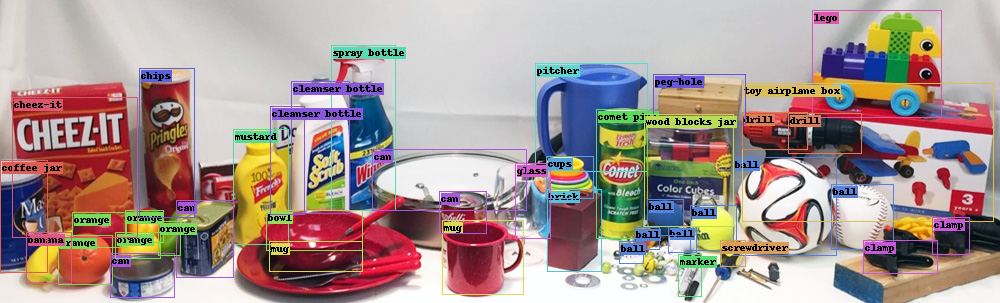

In [8]:
boxes, pred_classes, scores = filter_boxes(instances, threshold=0.45)

# mask = box_area(boxes) >= 1200
mask = box_area(boxes) >= 400

boxes = boxes[mask]
pred_classes = pred_classes[mask]
scores = scores[mask]

mask = ops.nms(boxes, scores, 0.3)

boxes = boxes[mask]
pred_classes = pred_classes[mask]

areas = box_area(boxes)
indexes = list(range(len(pred_classes)))
for c in torch.unique(pred_classes).tolist():
    box_id_indexes = (pred_classes == c).nonzero().flatten().tolist()
    for i in range(len(box_id_indexes)):
        for j in range(i+1, len(box_id_indexes)):
            bid1 = box_id_indexes[i]
            bid2 = box_id_indexes[j]

            arr1 = boxes[bid1].numpy()
            arr2 = boxes[bid2].numpy()
            a1 = np.prod(arr1[2:] - arr1[:2])
            a2 = np.prod(arr2[2:] - arr2[:2])
            top_left = np.maximum(arr1[:2], arr2[:2]) # [[x, y]]
            bottom_right = np.minimum(arr1[2:], arr2[2:]) # [[x, y]]
            wh = bottom_right - top_left
            # clip: if boxes not overlap then make it zero
            ia = wh[0].clip(0) * wh[1].clip(0)
            if ia >= 0.9 * min(a1, a2):
                if a1 >= a2:
                    if bid2 in indexes:
                        indexes.remove(bid2)
                else:
                    if bid1 in indexes:
                        indexes.remove(bid1)

boxes = boxes[indexes]
pred_classes = pred_classes[indexes]

print(len(pred_classes.unique()))
# boxes, pred_classes = filter_boxes(instances, threshold=0.7)


label_names = list_replace(label_names, old='mini soccer', new='ball')
colors = assign_colors(pred_classes, label_names, seed=4)

to_pil_image(draw_bounding_boxes(image, boxes, labels=[label_names[cid] for cid in pred_classes.tolist()], colors=colors))

In [84]:
box_iou?

Signature: box_iou(boxes1: torch.Tensor, boxes2: torch.Tensor) -> torch.Tensor
Docstring:
Return intersection-over-union (Jaccard index) between two sets of boxes.

Both sets of boxes are expected to be in ``(x1, y1, x2, y2)`` format with
``0 <= x1 < x2`` and ``0 <= y1 < y2``.

Args:
    boxes1 (Tensor[N, 4]): first set of boxes
    boxes2 (Tensor[M, 4]): second set of boxes

Returns:
    Tensor[N, M]: the NxM matrix containing the pairwise IoU values for every element in boxes1 and boxes2
File:      ~/miniconda3/envs/cora/lib/python3.9/site-packages/torchvision/ops/boxes.py
Type:      function

In [51]:
import matplotlib.pyplot as plt

In [49]:
protos = torch.load('./ycb_prototypes_v2.pth')['prototypes']

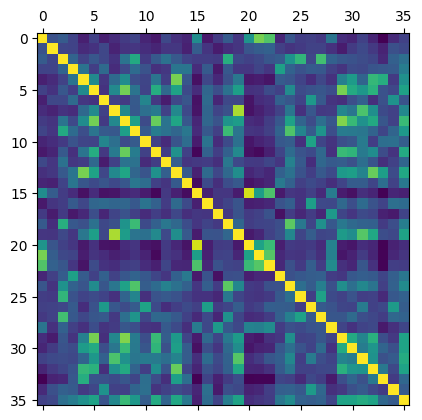

In [54]:
plt.matshow(protos @ protos.T)